In [1]:
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools
%matplotlib inline
%load_ext autoreload
%autoreload 2
import random
import pdb
# from multiprocessing import Process, Manager
# from multiprocessing import set_start_method

In [2]:
import sys
sys.path.insert(0, '/home/nkotelevskii/github/corrected_l2hmc/l2hmc_pytorch/l2hmc/utils/')
from func_utils_pt import acl_spectrum, ESS

In [3]:
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
# device = "cpu"
device

'cuda:1'

In [4]:
from distributions_pt import Gaussian
from layers_pt import Net
from dynamics_pt import Dynamics
from sampler_pt import propose
from notebook_utils_pt import get_hmc_samples

In [5]:
network = Net

In [6]:
x_dim = 2
T = 5

mu = np.zeros(2,)
mu = torch.tensor(mu).to(device)
cov = np.array([[50.05, -49.95], [-49.95, 50.05]])
cov = torch.tensor(cov).to(device)

distribution = Gaussian(mu, cov, device=device)
dynamics = Dynamics(x_dim, distribution.get_energy_function(), T=T, eps=0.1, net_factory=network, device=device)

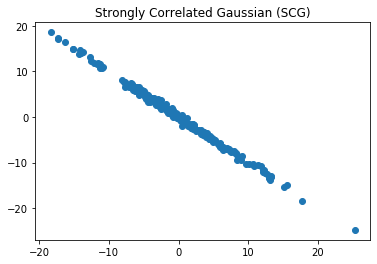

In [7]:
S = distribution.get_samples(200)
plt.title('Strongly Correlated Gaussian (SCG)')
plt.scatter(S[:, 0], S[:, 1])
plt.show()

In [8]:
n_batches = 5000
n_samples = 300
K = 10
scale = torch.tensor(0.1, device=device)

In [9]:
autoregressive_coeff_logit = nn.Parameter(torch.tensor(0., device=device, dtype=torch.float32))
params = list(dynamics.parameters()) + list([autoregressive_coeff_logit])
optim = Adam(params)

In [ ]:
scheduler = StepLR(optim, step_size=1000, gamma=0.96)
std_normal = torch.distributions.Normal(loc=torch.tensor(0., dtype=torch.float32, device=device),
                                                scale=torch.tensor(1., dtype=torch.float32, device=device))
torch_log_2 = torch.tensor(np.log(2.), device=device, dtype=torch.float32)

def compute_loss(z_new, p_new, z_old, p_old, sum_log_alpha, sum_log_jac):
    log_p = distribution.get_logdensity(z_new) + std_normal.log_prob(p_new).sum(1)
    log_r = -K * torch_log_2
    log_m = std_normal.log_prob(z_old).sum(1) + std_normal.log_prob(p_old).sum(1) - sum_log_jacobian + sum_log_alpha
    elbo_full = log_p + log_r - log_m
    grad_elbo = torch.mean(elbo_full + elbo_full.detach() * sum_log_alpha)
    return elbo_full.detach().mean().item(), grad_elbo

for t in tqdm(range(n_batches)):    
    z_old = torch.randn(n_samples, x_dim, dtype=torch.float32, device=device)
    p_old = torch.randn(n_samples, x_dim, dtype=torch.float32, device=device)
    optim.zero_grad()
    sum_log_alpha = torch.zeros(z_old.shape[0], dtype=torch.float32, device=device) # for grad log alpha accumulation
    sum_log_jacobian = torch.zeros(z_old.shape[0], dtype=torch.float32, device=device) # for log_jacobian accumulation
    
    z_new = z_old.detach()
    p_new = p_old.detach()
    
    for k in range(K):
        u = torch.randn(p_new.shape, dtype=torch.float32, device=device)
#         pdb.set_trace()
        _, p_prop, log_alpha, z_new, log_jac = propose(x=z_old, dynamics=dynamics,
                                                       init_v=p_new, do_mh_step=True, device=device, our_alg=True, use_barker=True)
        coeff = torch.sigmoid(autoregressive_coeff_logit)
        p_new = p_prop * coeff + torch.sqrt(1. - coeff**2) * u
        z_new = z_new[0]
        
        sum_log_alpha = sum_log_alpha + log_alpha
        sum_log_jacobian = sum_log_jacobian + log_jac + x_dim * torch.log(coeff)
        
    elbo_full, grad_elbo = compute_loss(z_new=z_new, p_new=p_new, z_old=z_old, p_old=p_old, sum_log_alpha=sum_log_alpha,
                                        sum_log_jac=sum_log_jacobian)
    (-grad_elbo).backward()
    optim.step()
    scheduler.step()
    #     pdb.set_trace()

    if t % 100 == 0:
        current_lr = None
        for param_group in optim.param_groups:
            current_lr = param_group['lr']
        print ('Step: %d / %d, ELBO: %.2e, LR: %.5f, Autoregressive Coef %.2f' % (t, n_batches, elbo_full, current_lr,
                                                                                torch.sigmoid(autoregressive_coeff_logit).cpu().detach().item()))

  0%|          | 1/5000 [00:01<2:29:28,  1.79s/it]

Step: 0 / 5000, ELBO: -1.93e+01, LR: 0.00100, Autoregressive Coef 0.50


  2%|▏         | 101/5000 [03:04<2:28:23,  1.82s/it]

Step: 100 / 5000, ELBO: -1.70e+01, LR: 0.00100, Autoregressive Coef 0.52


  3%|▎         | 137/5000 [04:09<2:28:25,  1.83s/it]

In [ ]:
length_of_chains = 200 #2000

In [ ]:
samples = torch.tensor(distribution.get_samples(n=n_samples), dtype=torch.float32, device=device)
final_samples = []

samples_ = samples
with torch.no_grad():
#     pdb.set_trace()
    for t in tqdm(range(length_of_chains)):
        final_samples.append(samples_.cpu().numpy())
        _, _, _, samples_, _ = propose(samples_, dynamics, do_mh_step=True, device=device)
        samples_ = samples_[0].detach()

In [ ]:
L2HMC_samples = np.array(final_samples)
with torch.no_grad():
    HMC_samples_1 = get_hmc_samples(2, 0.1, distribution.get_energy_function(), steps=length_of_chains, samples=samples, device=device)
    HMC_samples_2 = get_hmc_samples(2, 0.15, distribution.get_energy_function(), steps=length_of_chains, samples=samples, device=device)
    HMC_samples_3 = get_hmc_samples(2, 0.2, distribution.get_energy_function(), steps=length_of_chains, samples=samples, device=device)

In [ ]:
L2HMC_samples.shape

In [ ]:
HMC_samples_1.shape

In [ ]:
scale = np.sqrt(np.trace(cov.cpu().detach().numpy()))
L2HMC = acl_spectrum(L2HMC_samples, scale=scale)
HMC1 = acl_spectrum(HMC_samples_1, scale=scale)
HMC2 = acl_spectrum(HMC_samples_2, scale=scale)
HMC3 = acl_spectrum(HMC_samples_3, scale=scale)

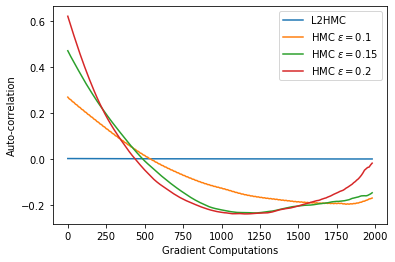

In [20]:
points_to_plot = np.min([300, length_of_chains - 1])
xaxis = 10 * np.arange(points_to_plot)
plt.plot(xaxis, L2HMC[:points_to_plot], label='L2HMC')
plt.plot(xaxis, HMC1[:points_to_plot], label='HMC $\epsilon=0.1$')
plt.plot(xaxis, HMC2[:points_to_plot], label='HMC $\epsilon=0.15$')
plt.plot(xaxis, HMC3[:points_to_plot], label='HMC $\epsilon=0.2$')
plt.ylabel('Auto-correlation')
plt.xlabel('Gradient Computations')
plt.legend()
plt.show()

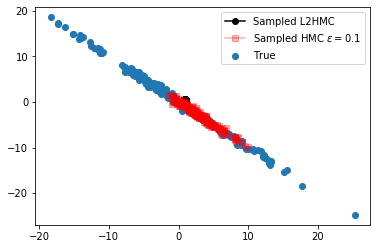

In [21]:
num = 0

points_to_plot = np.min([200, length_of_chains - 1])

plt.scatter(S[:points_to_plot, 0], S[:points_to_plot, 1], label='True')
plt.plot(L2HMC_samples[:points_to_plot, num, 0], L2HMC_samples[:points_to_plot, num, 1], label='Sampled L2HMC', color='black', marker='o')
plt.plot(HMC_samples_2[:points_to_plot, num, 0], HMC_samples_2[:points_to_plot, num, 1], label='Sampled HMC $\epsilon=0.1$', color='red', marker='s', alpha=0.3)
plt.legend()
plt.show()

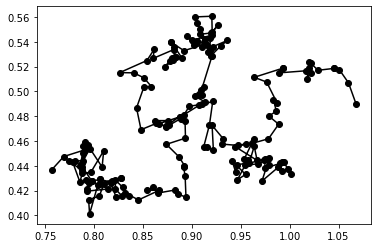

In [22]:
# num = 1
plt.plot(L2HMC_samples[:points_to_plot, num, 0], L2HMC_samples[:points_to_plot, num, 1], label='Sampled L2HMC', color='black', marker='o')